# Calculate Mg isotope fractionation along the chondritic liquidus

This notebook does all the steps to go from DFPT calculations 
and information about melt structrue to Br-melt fractionation.

It was a script - but moved to a notebook for incrememntal improvment
in the figures.

In [1]:
import numpy as np

import scipy.interpolate as spi
import scipy.optimize as spo

import bulk_run_phonons
import fit_beta_V
import process_PVT_castep
import bm3_eos as eos
import earthref
import ionic_model

earth_model = earthref.EarthModel(earthref.ak135)

# Define constants
eps0 = 8.854187817E-12 # Vacuum permittivity (F/m)
e = 1.60217662E-19 # electron charge (C)

# Conversion factors
m2ang = 1.0E10
j2ev = 6.242E18

In [2]:
def depth_PT(depth):
    """Retrun liquidus P and T at a given depth in a magma ocean

    Liquidus data Andrault et at. 2011 (EPSL doi:10.1016/j.epsl.2011.02.006)
    who fit a modified Simmon and Glatzel equation:

         T = T0 (P/a+1_^(1/c) 

    (see section 3.4) with parameters listed below. This replaces a
    previous linear fit to data at 0 and 60 GPa.
    """
    
    P = earth_model(6371-depth) # Interpolating AK135...
    # We now have P, T is from TP plot
    T_0 = 1940.0 # virtual liqidus temperature at 0 GPa
    a = 26.0 # GPa
    c = 1.9
    T = T_0 * ((P / a) + 1)**(1/c)
    return T, P

In [3]:
def fit_beta(files, supercell=False):

    paths_and_seeds = bulk_run_phonons.process_paths(files)
    data = fit_beta_V.get_data(paths_and_seeds, supercell=supercell)
    A1, A2, A3, B1, B2, B3, C1, C2, C3 = fit_beta_V.fit_beta_T_V(data, plot=False)

    def get_beta_T_V(T, V):
        return fit_beta_V.ln_beta_V_function_wrap(T, V, A1, A2, A3, B1, 
                                                 B2, B3, C1, C2, C3)

    return np.vectorize(get_beta_T_V)

In [4]:
def fit_PVT_EOS_params(files):

    data = []
    for f in files:
        print(f)
        data = process_PVT_castep.parse_castep_file(f, data)

    Ts = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500]
    Vs = []
    Fs = []
    K0s = []
    Kp0s = []
    E0s = []
    V0s = []
    for T in Ts:
        V, F = process_PVT_castep.get_VF(data, T)
        V0, E0, K0, Kp0 =  eos.fit_BM3_EOS(V, F, verbose=True)
        Vs.append(V)
        Fs.append(F)
        K0s.append(K0)
        Kp0s.append(Kp0)
        E0s.append(E0)
        V0s.append(V0)
    fV0, fE0, fK0, fKp0 = eos.fit_parameters_quad(Ts, V0s, E0s, K0s, Kp0s,
        plot=False)

    def get_volume(P, T):
        return eos.get_V(P, T, fV0, fK0, fKp0)

    return np.vectorize(get_volume)

## Main code - was in if __name__ == "__main__" condition...

In [5]:
import glob

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Depth range of interest
depths = np.linspace(0.0, 2800.0, num=200)

# Set some special depths so we can tabulate
special_depths = [1000, 1500, 2000, 2500]
for special_depth in special_depths:
    idx = (np.abs(depths - special_depth)).argmin()
    print("Depth was ", depths[idx])
    depths[idx] = special_depth
    print("Depth is ", depths[idx])

# Get our list of Ps and Ts
Ts, Ps = depth_PT(depths)

Depth was  998.9949748743719
Depth is  1000.0
Depth was  1505.5276381909548
Depth is  1500.0
Depth was  1997.9899497487438
Depth is  2000.0
Depth was  2504.522613065327
Depth is  2500.0


## Read in phonon frequencies and fir PVT EOS

In [7]:
# Volume of MgO
MgO_eos = fit_PVT_EOS_params(
        glob.glob('../free_energy/MgO/MgO_*GPa/MgO.castep'))
MgO_Vs = MgO_eos(Ps, Ts)
MgO_Vs_athermal = MgO_eos(Ps, np.zeros_like(Ts))

# Volume of MgSiO3 Pv
MgSiO3_eos = fit_PVT_EOS_params(
        glob.glob('../free_energy/MgSiO3/MgSiO3_*GPa/MgSiO3.castep'))
MgSiO3_Vs = MgSiO3_eos(Ps, Ts)
MgSiO3_Vs_athermal = MgSiO3_eos(Ps, np.zeros_like(Ts))
    
# Volume of MgSiO3 Pv
Mg2SiO4_eos = fit_PVT_EOS_params(
        glob.glob('../free_energy/Mg2SiO4/Mg2SiO4_*GPa/Mg2SiO4.castep'))
Mg2SiO4_Vs = Mg2SiO4_eos(Ps, Ts)
Mg2SiO4_Vs_athermal = Mg2SiO4_eos(Ps, np.zeros_like(Ts))


../free_energy/MgO/MgO_90GPa/MgO.castep
../free_energy/MgO/MgO_80GPa/MgO.castep
../free_energy/MgO/MgO_140GPa/MgO.castep
../free_energy/MgO/MgO_130GPa/MgO.castep
../free_energy/MgO/MgO_120GPa/MgO.castep
../free_energy/MgO/MgO_100GPa/MgO.castep
../free_energy/MgO/MgO_110GPa/MgO.castep
../free_energy/MgO/MgO_0GPa/MgO.castep
../free_energy/MgO/MgO_-10GPa/MgO.castep
../free_energy/MgO/MgO_30GPa/MgO.castep
../free_energy/MgO/MgO_20GPa/MgO.castep
../free_energy/MgO/MgO_10GPa/MgO.castep
../free_energy/MgO/MgO_50GPa/MgO.castep
../free_energy/MgO/MgO_40GPa/MgO.castep
../free_energy/MgO/MgO_60GPa/MgO.castep
../free_energy/MgO/MgO_70GPa/MgO.castep
Fitted 3rd order Birch-Murnaghan EOS parameters:
 E0  = -1986.91 eV
 V0  = 77.9437 A**3
 K0  = 0.923514 eV.A**-3 ( = 147.964 GPa)
 K0' = 4.19658
Fitted 3rd order Birch-Murnaghan EOS parameters:
 E0  = -1987.38 eV
 V0  = 78.9252 A**3
 K0  = 0.868551 eV.A**-3 ( = 139.158 GPa)
 K0' = 4.25836
Fitted 3rd order Birch-Murnaghan EOS parameters:
 E0  = -1988.83 

## Fit beta for these volumes 

Runs phonons if needed, deep into my modules

In [8]:
# 1000.ln(beta) for MgO
MgO_beta_fun = fit_beta(glob.glob('../free_energy/MgO/MgO_*GPa/MgO.castep')) 
MgO_betas = MgO_beta_fun(Ts, MgO_Vs)
MgO_betas_athermal = MgO_beta_fun(Ts, MgO_Vs_athermal)

# 1000.ln(beta) for MgSiO3
MgSiO3_beta_fun = fit_beta(glob.glob('../free_energy/MgSiO3/MgSiO3_*GPa/MgSiO3.castep')) 
MgSiO3_betas = MgSiO3_beta_fun(Ts, MgSiO3_Vs)
MgSiO3_betas_athermal = MgSiO3_beta_fun(Ts, MgSiO3_Vs_athermal)

# 1000.ln(beta) for Mg2SiO3
Mg2SiO4_beta_fun = fit_beta(glob.glob('../free_energy/Mg2SiO4/Mg2SiO4_*GPa/Mg2SiO4.castep')) 
Mg2SiO4_betas = Mg2SiO4_beta_fun(Ts, Mg2SiO4_Vs)
Mg2SiO4_betas_athermal = Mg2SiO4_beta_fun(Ts, Mg2SiO4_Vs_athermal)

Extracting data from MgO in ../free_energy/MgO/MgO_90GPa
Reusing existing .phonon files
Total q-points: 220

Extracting data from MgO in ../free_energy/MgO/MgO_80GPa
Reusing existing .phonon files
Total q-points: 220

Extracting data from MgO in ../free_energy/MgO/MgO_140GPa
Reusing existing .phonon files
Total q-points: 220

Extracting data from MgO in ../free_energy/MgO/MgO_130GPa
Reusing existing .phonon files
Total q-points: 220

Extracting data from MgO in ../free_energy/MgO/MgO_120GPa
Reusing existing .phonon files
Total q-points: 220

Extracting data from MgO in ../free_energy/MgO/MgO_100GPa
Reusing existing .phonon files
Total q-points: 220

Extracting data from MgO in ../free_energy/MgO/MgO_110GPa
Reusing existing .phonon files
Total q-points: 220

Extracting data from MgO in ../free_energy/MgO/MgO_0GPa
Reusing existing .phonon files
Total q-points: 220

Extracting data from MgO in ../free_energy/MgO/MgO_-10GPa
Reusing existing .phonon files
Total q-points: 220

Extracting dat

/Users/andreww/miniforge3/envs/py311/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/andreww/Desktop/Castep-isotopes-work/isofrac/fit_beta_V.py:104: UserWarning: Fit does not reproduce data to better than 0.05 per mil!
  warnings.warn("Fit does not reproduce data to better than 0.05 per mil!")


For function:
  1000 ln(beta) = (A1+A2.V^-1+A3.V^-2)/T^6 + (B1+B2.V^-1+B3.V^-2)/T^4 + (C1+C2.V-1+C3.V-2)/T^2
parameters are: 
  A1 = -6.35909e+15 	   B1 = -2.87176e+11 	   C1 = 2.81164e+06
  A2 = 4.7421e+17 	   B2 = 4.84384e+13 	   C2 = -6.06758e+08
  A3 =       0 	   B3 = -2.10046e+15 	   C3 = 4.46569e+10
maximum error is: 0.184797
Extracting data from MgSiO3 in ../free_energy/MgSiO3/MgSiO3_90GPa
Reusing existing .phonon files
Total q-points: 250

Extracting data from MgSiO3 in ../free_energy/MgSiO3/MgSiO3_80GPa
Reusing existing .phonon files
Total q-points: 250

Extracting data from MgSiO3 in ../free_energy/MgSiO3/MgSiO3_0GPa
Reusing existing .phonon files
Total q-points: 250

Extracting data from MgSiO3 in ../free_energy/MgSiO3/MgSiO3_-10GPa
Reusing existing .phonon files
Total q-points: 250

Extracting data from MgSiO3 in ../free_energy/MgSiO3/MgSiO3_50GPa
Reusing existing .phonon files
Total q-points: 250

Extracting data from MgSiO3 in ../free_energy/MgSiO3/MgSiO3_40GPa
Reusing e

## Report key data for solids

In [9]:
print("Done fitting... now some key data" )
print("P(GPa) T(K) Depth(km), 1000.ln(alpha(Fo, MgO)), 1000.ln(alpha(Fo,MgPv)")
for P, T, D, B_Fo, B_MgO, B_MgPv in zip(Ps, Ts, depths, Mg2SiO4_betas, MgO_betas, MgSiO3_betas):
    print(P, T, D, B_Fo-B_MgO, B_Fo-B_MgPv)

Done fitting... now some key data
P(GPa) T(K) Depth(km), 1000.ln(alpha(Fo, MgO)), 1000.ln(alpha(Fo,MgPv)
0.0 1940.0 0.0 -0.004748691718410081 0.023685534153199572
0.33861741941468193 1953.2571729509848 14.07035175879397 -0.0027223203857753564 0.026622986850804997
0.6988161226827759 1967.270957792848 28.14070351758794 -0.0006508614735495355 0.029626761456850892
1.1165362872000484 1983.4109761144416 42.21105527638191 0.001648493159112252 0.0329620135674209
1.5740191021056613 2000.9528166450875 56.28140703517588 0.00404706650990716 0.036442143679498495
2.0315019170112447 2018.3573295535095 70.35175879396985 0.006328017851412848 0.03975232704372672
2.489467990014953 2035.6459790406816 84.42211055276383 0.008500703335609872 0.04290583627236427
2.9479331081326356 2052.822104229228 98.49246231155779 0.010571458472232675 0.04591160190760896
3.406398226250348 2069.8698494700757 112.56281407035176 0.012543994774022016 0.04877478126354334
3.8668490695272846 2086.8651797322123 126.63316582914574 0

## Melt functions (ionic model plus corrections)

In [10]:
def kf(r0, zi, zj, n):
    """
    Calculate force constant for Born-Mayer type interionic potential
    
    r_0 - equilibrium distance between ions (m); can be array
    zi, zj - charges on ions (electrons)
    n - exponent for repulsive part (-); typically ~12
    returns force constant (J/m^n)
    """
    k = (zi * zj * e**2 * (1-n)) / (4.0 * np.pi * eps0 * r0**3)
    return k

In [11]:
def calc_beta_model(r, coord, t, qfac0, qfac1, qfacgrd):
    qfac = qfac0 + r*qfac1 + coord*qfacgrd
    n = 12
    k = kf(r*1E-10, 2.0*qfac, -2.0*qfac, n)
    beta = ionic_model.ionic_model_beta(k, t) 
    return beta

In [12]:
def find_beta_qfac0(r, coord, t, qfac0, qfac1, qfacgrd, target):

    def func(qf):
        return calc_beta_model(r, coord, t, qf, qfac1, qfacgrd) - target

    print("-5", func(-5.0))
    print("-2", func(-2.0))
    print("-1", func(-1.0))
    print("0", func(0.0))
    print("2", func(2.0))
    print("5", func(5.0))
    new_qf, r = spo.brentq(func, 2.0, 5.0, full_output=True)
    print(r)
    return new_qf

In [13]:
def find_pressure_correction(melt_poly_coef, melt_coord_spline, t, qf, qfac1, qfacgrd, target):

    def err_func(dp):
        r = ionic_model.melt_bond_length(dp, melt_poly_coef)*1E10
        coord = melt_coord_spline(dp)
        return calc_beta_model(r, coord, t, qf, qfac1, qfacgrd) - target

    dp, rootres = spo.brentq(err_func, -10.0, 10.0, full_output=True)
    print(rootres)
    return dp

## Now deal with the melt

In [14]:
print("Sorting out the melt")

melt_poly_coef = [1.9613, -0.00165, 0.0000019]
    
melt_coord_val = np.array(([4.93, 5.4, 6, 6.7, 7.25, 7.62, 7.85]))
melt_coord_pressure = np.array(([0.1, 2.5, 7.2, 16.3, 34.3, 72.1, 159.4]))
coord_spline = spi.InterpolatedUnivariateSpline(melt_coord_pressure, melt_coord_val)
    
all_popt = [ 2.32716768, -0.93910997,  0.06109785] # From fitting MgO

# Correction to match empirical observations for olivine - melt
# From Liu et al 2022 (published now).
measured_fractionation = 0.071
measured_temperature = 1438.0
measured_pressure = 0.0
    
r_melt = ionic_model.melt_bond_length(0.0, melt_poly_coef)
coord_melt = coord_spline(0.0)
beta_melt = calc_beta_model(r_melt*1E10, coord_melt, measured_temperature, *all_popt)
beta_ol = Mg2SiO4_beta_fun(measured_temperature, Mg2SiO4_eos(measured_pressure, measured_temperature)) 
print("Calculated melt is:",
        beta_melt,
        "per mill")
print("Calculated Fo frac is:",
        beta_ol,
        "per mill")
print("Calculated melt - Fo frac is:",
        beta_melt - beta_ol,
        "per mill")
print("Observed melt - Fo frac is:", measured_fractionation, "per mill") 

print("Applying model correction for pressure")
dp = find_pressure_correction(melt_poly_coef, coord_spline, measured_temperature, all_popt[0], 
                             all_popt[1], all_popt[2], measured_fractionation + beta_ol)
print("dp is", dp)

beta_melt = calc_beta_model(ionic_model.melt_bond_length(dp, melt_poly_coef)*1E10, coord_spline(dp), measured_temperature, *all_popt)
print("Calculated melt - Fo frac is NOW:",
    beta_melt - beta_ol,
    "per mill")
print("Observed melt - Fo frac is:", measured_fractionation, "per mill") 
    
melt_ln_betas = calc_beta_model(ionic_model.melt_bond_length(Ps+dp, melt_poly_coef)*1E10,
                                    coord_spline(Ps+dp), Ts, *all_popt)

# And again for the athermal case
beta_ol_athermal = Mg2SiO4_beta_fun(measured_temperature, Mg2SiO4_eos(measured_pressure, 0.0)) 
print("Applying model correction for pressure")
dpa = find_pressure_correction(melt_poly_coef, coord_spline, measured_temperature, all_popt[0], 
                             all_popt[1], all_popt[2], measured_fractionation + beta_ol_athermal)
print("dp is", dpa)
melt_ln_betas_athermal = calc_beta_model(ionic_model.melt_bond_length(Ps+dpa, melt_poly_coef)*1E10,
                                    coord_spline(Ps+dpa), Ts, *all_popt)

print("Done fitting... now plotting")

Sorting out the melt
Calculated melt is: 1.880080227457996 per mill
Calculated Fo frac is: 0.9678668695354584 per mill
Calculated melt - Fo frac is: 0.9122133579225375 per mill
Observed melt - Fo frac is: 0.071 per mill
Applying model correction for pressure
      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: -7.828595467012896
dp is -7.828595467012896
Calculated melt - Fo frac is NOW: 0.07099999999993267 per mill
Observed melt - Fo frac is: 0.071 per mill
Applying model correction for pressure
      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: -6.418193998016731
dp is -6.418193998016731
Done fitting... now plotting


## Figure 6 

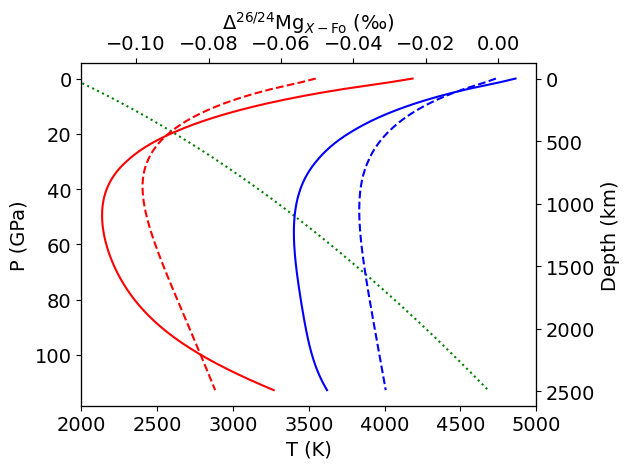

In [15]:
f, ax1 = plt.subplots()

fs = 14
fs_l = fs

max_depth = 2500.0
ax_depths = depths[depths<max_depth]
ax_Ts, ax_Ps = depth_PT(ax_depths)
ax1.invert_yaxis()
ax1.plot(ax_Ts, ax_Ps, ':g')
ax1.set_xlim(left=2000, right=5000)
ax1.set_xlabel("T (K)", fontsize=fs)
ax1.set_ylabel("P (GPa)", fontsize=fs)
ax1.tick_params(axis='both', which='both', labelsize=fs_l)

ax2 = ax1.twinx()
ax2.invert_yaxis()
ax2.plot(ax_Ts, ax_depths, alpha=0) # invisable
ax2.set_ylabel("Depth (km)", fontsize=fs)
ax2.tick_params(axis='both', which='both', labelsize=fs_l)
ax3 = ax2.twiny()
ax3.set_xlabel(r"$\Delta^{26/24}$Mg$_{X-\mathrm{Fo}}$ (" + u'\u2030' + ")", fontsize=fs)

ax3.tick_params(axis='both', which='both', labelsize=fs_l)
ax3.plot((MgO_betas_athermal[depths<max_depth] - Mg2SiO4_betas_athermal[depths<max_depth]), depths[depths<max_depth], 'b--')
ax3.plot((MgO_betas[depths<max_depth] - Mg2SiO4_betas[depths<max_depth]), depths[depths<max_depth], 'b-')
ax3.plot((MgSiO3_betas[depths<max_depth] - Mg2SiO4_betas[depths<max_depth]), depths[depths<max_depth], 'r-')
ax3.plot((MgSiO3_betas_athermal[depths<max_depth] - Mg2SiO4_betas_athermal[depths<max_depth]), depths[depths<max_depth], 'r--')

f.tight_layout()
plt.show()

# Figure 9

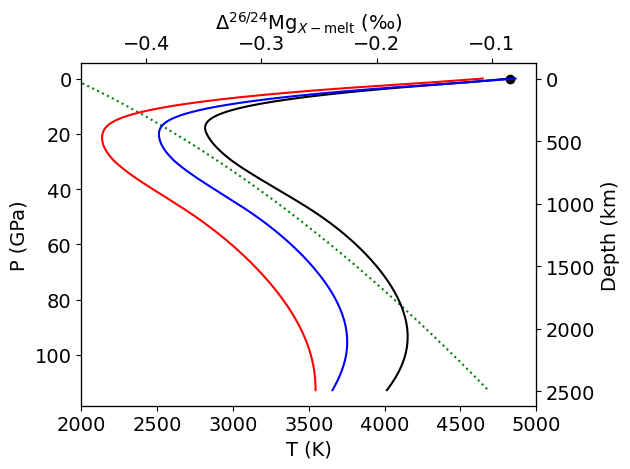

In [16]:
f, ax1 = plt.subplots()

fs = 14
fs_l = fs

max_depth = 2500.0
ax_depths = depths[depths<max_depth]
ax_Ts, ax_Ps = depth_PT(ax_depths)
ax1.invert_yaxis()
ax1.plot(ax_Ts, ax_Ps, ':g')
ax1.set_xlim(left=2000, right=5000)
ax1.set_xlabel("T (K)", fontsize=fs)
ax1.set_ylabel("P (GPa)", fontsize=fs)
ax1.tick_params(axis='both', which='both', labelsize=fs_l)

ax2 = ax1.twinx()
ax2.invert_yaxis()
ax2.plot(ax_Ts, ax_depths, alpha=0) # invisable
ax2.set_ylabel("Depth (km)", fontsize=fs)
ax2.tick_params(axis='both', which='both', labelsize=fs_l)
ax3 = ax2.twiny()
ax3.set_xlabel(r"$\Delta^{26/24}$Mg$_{X-\mathrm{melt}}$ (" + u'\u2030' + ")", fontsize=fs)

ax3.tick_params(axis='both', which='both', labelsize=fs_l)

ax3.plot((Mg2SiO4_betas[depths<max_depth] - melt_ln_betas[depths<max_depth]), depths[depths<max_depth], 'k-')
ax3.plot((Mg2SiO4_betas[depths==0.0] - melt_ln_betas[depths==0.0]), depths[depths==0.0], 'ko')
ax3.plot((MgO_betas[depths<max_depth] - melt_ln_betas[depths<max_depth]), depths[depths<max_depth], 'b-')
ax3.plot((MgSiO3_betas[depths<max_depth] - melt_ln_betas[depths<max_depth]), depths[depths<max_depth], 'r-')

    
f.tight_layout()

plt.show()

# Finally make a table

In [43]:

print(r"\begin{tabular}{ccccccc}")
print(r"\hline\noalign{\smallskip}")
print("Depth & Pressure & Temperature & \multicolumn{4}{c}{$1000 \ln(\\beta)$} \\\\")
print(" (km) &  (GPa) & (K) & Fo & Bdm & MgO & melt \\\\")
print(r"\noalign{\smallskip}\hline\noalign{\smallskip}")

for d in special_depths:
    t, p = depth_PT(d)
    beta_Fo = Mg2SiO4_betas[depths==d][0]
    beta_Br = MgSiO3_betas[depths==d][0]
    beta_MgO = MgO_betas[depths==d][0]
    beta_melt = melt_ln_betas[depths==d][0]
    print(f"{d} & {p:3.0f} & {t:4.0f} & {beta_Fo:4.3f} & {beta_Br:4.3f} & {beta_MgO:4.3f} & {beta_melt:4.3f}\\\\")
    
print(r"\noalign{\smallskip}\hline")
print(r"\end{tabular}")

\begin{tabular}{ccccccc}
\hline\noalign{\smallskip}
Depth & Pressure & Temperature & \multicolumn{4}{c}{$1000 \ln(\beta)$} \\
 (km) &  (GPa) & (K) & Fo & Br & MgO & melt \\
\noalign{\smallskip}\hline\noalign{\smallskip}
1000 &  39 & 3136 & 0.388 & 0.278 & 0.332 & 0.653\\
1500 &  62 & 3691 & 0.353 & 0.247 & 0.297 & 0.553\\
2000 &  87 & 4204 & 0.314 & 0.222 & 0.261 & 0.488\\
2500 & 113 & 4692 & 0.250 & 0.189 & 0.203 & 0.442\\
\noalign{\smallskip}\hline
\end{tabular}
